In [20]:
from csv import reader
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
import math

In [21]:
def load_dataset(dataset_path,n_train_data):
    """
    加载数据集，并对数据集进行简单处理，划分验证集、训练集
    :param dataset_path 数据集的路径
    :param n_train_data 训练集数据个数
    :return 训练集 验证集
    """
    dataset = []
    label_name = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
    # 读取并转化数据的格式
    with open(dataset_path,'r') as file:
        csv_reader = reader(file,delimiter = ',')
        for row in csv_reader:
            row[0:5] = list(map(float,row[0:5]))
            row[5] = label_name[row[5]]
            dataset.append(row)
     # 对数据进行归一化处理
    dataset = np.array(dataset)
    mms = MinMaxScaler()
    for i in range(dataset.shape[1] - 1):
        dataset[:, i] = mms.fit_transform(dataset[:, i].reshape(-1, 1)).flatten()
     # 将类标转为整型
    #dataset = dataset.tolist()
    for row in dataset:
        row[5] = int(row[5])
    # 打乱数据集
    random.shuffle(dataset)

    # 划分训练集和验证集
    train_data = dataset[0:n_train_data]
    val_data = dataset[n_train_data:]

    return train_data, val_data

In [56]:
def sigmoid(z):
    """激活函数(Sigmoid)：f(z) = Sigmoid(z)
    :param z: 神经元的输入
    :return: 神经元的输出
    """
    return 1.0 / (1.0 + np.exp(-z))


def sigmoid_derivative(output):
    """Sigmoid激活函数求导
    :param output: 激活函数的输出值
    :return: 求导计算结果
    """
    return output * (1.0 - output)

In [73]:
def fun_z(weights, inputs):
    """计算神经元的输入：z = weight * inputs + b
    :param weights: 网络参数（权重矩阵和偏置项）
    :param inputs: 上一层神经元的输出
    :return: 当前层神经元的输入
    """
    return np.dot(weights[:,:-1],inputs) + weights[:,-1]

In [45]:
def forward_propagate(network, inputs):
    """前向传播计算
    :param network: 神经网络
    :param inputs: 一个样本数据
    :return: 前向传播计算的结果
    """
    for layer in network:  # 循环计算每一层
        z = fun_z(layer['weights'],inputs)
        layer['output'] = sigmoid(z)
        inputs = layer['output']
    return inputs

In [88]:
def backward_propagate_error(network, actual_label):
    """误差进行反向传播
    :param network: 神经网络
    :param actual_label: 真实的标签值
    :return:
    """
    for i in reversed(range(len(network))):  # 从最后一层开始计算误差
        layer = network[i]
        #errors = np.empty()
        if i != len(network)-1:  # 不是输出层
            next_layer = network[i+1]

            errors = np.matmul(next_layer['weights'][:,:-1].T,next_layer['delta']) # 可能要进行转置等运算
                
        else:  # 输出层
            errors = actual_label - layer['output']
          
        # 计算误差项 delta
        layer['delta'] = errors * sigmoid_derivative(layer['output'])

In [60]:
print(np.dot(np.array([1,1,2]) , np.array([1,1,3])))
print(1 -np.array([1,1,3]))
print(np.array([1,1,2]) * np.array([1,3,3]))
print(np.matmul(np.array([[1,2,3],[1,2,3]]).T,np.array([1,1]).T))

8
[ 0  0 -2]
[1 3 6]
[2 4 6]


In [112]:
def update_parameters(network, row, l_rate):
    """利用误差更新神经网络的参数（权重矩阵和偏置项）
    :param network: 神经网络
    :param row: 一个样本数据
    :param l_rate: 学习率
    :return:
    """
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:  # 获取上一层网络的输出
            inputs = network[i-1]['output']
           #inputs = [neuron['output'] for neuron in network[i - 1]]
       # print(network[i]['weights'][:,-1])
       # print( network[i]['weights'])
        network[i]['weights'][:,-1] += l_rate * network[i]['delta']
        temparray = np.empty((network[i]['delta'].shape[0],inputs.shape[0]))
        for ii in range(network[i]['delta'].shape[0]):
            for jj in range(inputs.shape[0]):
                temparray[ii,jj] = network[i]['delta'][ii] * inputs[jj]
        network[i]['weights'][:,:-1] += l_rate * temparray
        
     
         

In [128]:
def initialize_network(n_inputs, n_hidden, n_outputs):
    """初始化BP网络（初始化隐藏层和输出层的参数：权重矩阵和偏置项）
    :param n_inputs: 特征列数
    :param n_hidden: 隐藏层神经元个数
    :param n_outputs: 输出层神经元个数，即分类的总类别数
    :return: 初始化后的神经网络
    """
    network = list()
    # 隐藏层
    
    hidden_layer = {'weights': np.array([[random.random() for i in range(n_inputs + 1)]for i in range(n_hidden)])}
    #hidden_layer = [{'weights': [random.random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    # 输出层
    output_layer = {'weights':np.array([[random.random() for i in range(n_hidden + 1)]for i in range(n_outputs)])}
    #output_layer = [{'weights': [random.random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    return network

In [78]:
def train(train_data, l_rate, epochs, n_hidden, val_data):
    """训练神经网络（迭代n_epoch个回合）
    :param train_data: 训练集
    :param l_rate: 学习率
    :param epochs: 迭代的回合数
    :param n_hidden: 隐藏层神经元个数
    :param val_data: 验证集
    :return: 训练好的网络
    """
    # 获取特征列数
    n_inputs = len(train_data[0]) - 1
    # 获取分类的总类别数
    n_outputs = len(set([row[-1] for row in train_data]))
    # 初始化网络
    network = initialize_network(n_inputs, n_hidden, n_outputs)

    acc = []
    for epoch in range(epochs):  # 训练epochs个回合
        for row in train_data:
            # 前馈计算
            _ = forward_propagate(network, row[:-1])
            #print(row[-1])
            # 处理一下类标，用于计算误差  类似于 onehot
            actual_label = np.zeros(n_outputs,dtype = int)
            actual_label[int(row[-1])] = 1
          
            # 误差反向传播计算
            backward_propagate_error(network, actual_label)
            # 更新参数
            update_parameters(network, row, l_rate)
        # 保存当前epoch模型在验证集上的准确率
        acc.append(validation(network, val_data))
    # 绘制出训练过程中模型在验证集上的准确率变化
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(acc)
    plt.show()

    return network

In [114]:
def validation(network, val_data):
    """测试模型在验证集上的效果
    :param network: 神经网络
    :param val_data: 验证集
    :return: 模型在验证集上的准确率
    """
    # 获取预测类标
    predicted_label = []
    for row in val_data:
        prediction = predict(network, row[:-1])
        predicted_label.append(prediction)
    # 获取真实类标
    actual_label = [row[-1] for row in val_data]
    # 计算准确率
    accuracy = accuracy_calculation(actual_label, predicted_label)
    # print("测试集实际类标：", actual_label)
    # print("测试集上的预测类标：", predicted_label)
    return accuracy

In [140]:
def accuracy_calculation(actual_label, predicted_label):
    """计算准确率
    :param actual_label: 真实类标
    :param predicted_label: 模型预测的类标
    :return: 准确率（百分制）
    """
    correct_count = 0
    for i in range(len(actual_label)):
        if actual_label[i] == predicted_label[i]:
            correct_count += 1
    return correct_count / float(len(actual_label)) * 100.0


def predict(network, row):
    """使用模型对当前输入的数据进行预测
    :param network: 神经网络
    :param row: 一个数据样本
    :return: 预测结果
    """
    outputs = forward_propagate(network, row)
    return np.argmax(outputs,axis=0)
   # return outputs.index(max(outputs))

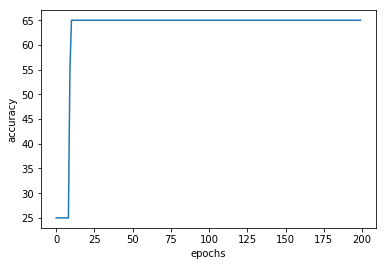

In [145]:
if __name__ == "__main__":
    file_path = 'data/iris.csv'

    # 参数设置
    l_rate = 0.2  # 学习率
    epochs = 200  # 迭代训练的次数
    n_hidden = 5  # 隐藏层神经元个数
    n_train_data = 130  # 训练集的大小（总共150条数据，训练集130条，验证集20条）

    # 加载数据并划分训练集和验证集
    train_data, val_data = load_dataset(file_path, n_train_data)
    # 训练模型
    network = train(train_data, l_rate, epochs, n_hidden, val_data)

ValueError: operands could not be broadcast together with shapes (3,) (5,) 